# Assignment 6: Classification with Logistic Regression

# Total: 16 Marks + 2 Bonus Marks

## Instructions

* Complete the assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline

## The Dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

You can read more about the data and the variables [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportion_confint
from sklearn.utils.multiclass import unique_labels

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Part A: 1 Mark

Read in the `diabetes.csv` dataset.

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

X = df.drop(['Outcome'], axis=1)

y = df['Outcome']

len(df)

768

## Part B: 1 Mark

Split the data into train and test.  Hold out 50% of observations as the test set.  Pass `random_state=0` to `train_test_split` to ensure you get the same train and tests sets as the solution.

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.5, random_state=0)

train_X.shape, train_y.shape

((384, 8), (384,))

## Part C: 3 Marks

Read the documentation for [sklearn's `LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).  In no more than 2 sentences per bullet point, answer the following in your own words.

* Does `LogisticRegression` use a penalty by default?  If yes, what penalty?  If it does, does this mean that `LogisticRegression` actually uses ridge regression or the LASSO as the default?



* What is the interpretation of the parmater `C`?  How does it relate to the regularization strength $\lambda$?



* If I were to ask you to use a regularization strengh of 2 (i.e. $\lambda=2$), what value of `C` would you pass?



1. Yes, Logistic Regression in sklearn uses an L2 penalty by default. The sklearn implementation by default uses Ridge unless you change the penalty term to L1, then it would be a LASSO.

2. The C parameter is the inverse of the regularization strength lamda. By decreasing C we increase the regalarization strength. It keeps the weight coefficients small as you decrease C.

3. C = 1/lambda -> C = 1/2 

## Part D: 1 Mark

Create a pipeline for logistic regression (that is, the unpenalized version).  You will need to choose an alternative solver for `LogisticRegression` since the default solver does not support the no penalty option. Any solver will do, so just take a look at the docs to see what is available. I used `solver="newton-cg"` which seems to work fine.

If you get a warning about convergence of `coef_`, try increasing the `max_iter` parameter.  I used `max_iter=10000` which seems to supress the warning.

In [14]:
lr_pipe = Pipeline([('lr', LogisticRegression(penalty='none', solver='newton-cg', max_iter=10000))])

In [15]:
lr = lr_pipe.fit(train_X, train_y)

In [16]:
y_pred = lr.predict(test_X)

classes = np.array([0,1])

## Part E: 3 Marks

Use your model to construct a confusion matrix by fitting and predicting on the training data (I've inlcluded a little helper function to make looking at the confusion matrix a little easier). Then answer the following using the confusion matrix (don't use sklearn's functions):

* What is your model's training accuracy?
  ACC = 1 - ERR
  ERR = FP + FN / FP + FN + TP + TN
  ERR = 98 + 108 / 98 + 108 + 39 + 175
  ACC = 1 - ERR = 1 - 0.49 = 0.51
* What is your model's training precision?
  Precision = TP / TP + FP
  Precision = 39 / 39 + 98
  Precision = 0.285
* What is your model's training recall?
  Recall = TP / FN + TP
  Recall = 39 / 108 + 39
  Recall = 0.265

Confusion matrix, without normalization


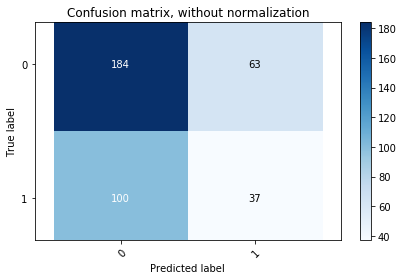

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax

plot_confusion_matrix(train_y, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

## Part F:  1 Mark

Estimate logistic regressions out of sample recall by using 5 fold cross validation.

In [18]:
cv_scores = cross_val_score(lr_pipe, train_X, train_y, 
                            cv=5, scoring=make_scorer(recall_score))
print('The out of sample recall is: %s' % cv_scores.mean())



The out of sample recall is: 0.5473544973544974


# Part F: 2 Marks

Create a new pipeline for either an l2 penalty in logistic regression or an l1 penalty.  Remember, penalized models perform best when you scale the inputs.  You should add `StandardScaler()` to your pipeline.

In [19]:
lrps = Pipeline([('standardize', StandardScaler()), ('lr', LogisticRegression(penalty='l2', solver='newton-cg', max_iter=10000))])

## Part F: 2 Marks

  Use sklearn's `GridSearchCV` to search over the regulatization strength ranging from 0.01 to 10 in 25 evenly spaced increments for you model.  Use recall as your metric for scoring.
  

`GridSearchCV` is a way to cross validate your models for a variety of parameters.  Read more about `GridSearchCV` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [20]:
param_range = np.arange(0.01,10.0,0.4)

param_grid = {'lr__C': param_range}

gs = GridSearchCV(estimator=lrps,
                  param_grid=param_grid,
                 scoring='recall',
                 cv=10,
                 n_jobs=-1)

gs.fit(train_X, train_y)

/Users/BigAL/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardize',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=10000,
                                                           multi_clas

## Part G: 1 Mark

What was the cross validated recall for your regularized model?  If you called your model grid search `lasso_gscv` you can access the best model's score by performing `lasso_gscv.best_score_`.


In [11]:
print('The best score during GridSearch CV was: %s' % gs.best_score_)


The best score during GridSearch CV was: 0.6071714743589743


## Part H:  2 Marks

Print out the `C` parameter for your regualized model.  Answer the following:

* From this value what is the regularization strength $\lambda$?  



* In 1-2 sentences, would you prefer a regularized model for this dataset?  When might a regularized model make more sense?



In [12]:
print('The best C value from our grid search is: %s' % gs.best_params_['lr__C'])
print('Lamda = %s' % (1/gs.best_params_['lr__C']))

The best C value from our grid search is: 6.41
Lamda = 0.15600624024961


# BONUS: 2 Marks

The following is a bonus question worth 2 marks. If you do not answer this question, there is no penalty.  You can't earn more than 100% on this assignment.

LASSO and other penalized estimators make the assumption that the model is what we call *sparse* (that means, not every variable is actually related to the outcome).  We can see which variables are more important than others by examining what is known as the *coefficient paths*.

Here are the steps to create the coefficient path:

1) Initialize an array of regularization strengths (typically going from something very small, maybe 0.1, to something very large, maybe 100.

2) For each regularization strength, fit your model.  Keep track of the coefficients.

3) Plot the coefficient values against the log of the regularization strength.


You've done this correctly if you can create a plot which looks like [this](https://cvxpy.readthedocs.io/en/latest/_images/lasso_regression_11_0.svg).

To earn the bonus marks, do the following:

* Construct the coefficient path for logistic regression with an l1 penalty.
* Determine which coefficient is most strongly related to the outcome be examining which coefficent reaches 0 last.




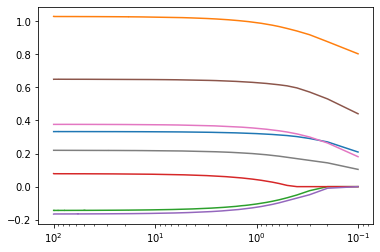

In [67]:
def plotCoefficientPath(train_X, test_y):
    
    scale = StandardScaler()
    
    std_train_X = scale.fit_transform(train_X)
    
    param_range = np.arange(0.1,100, 0.1)
    
    param_grid = {'lr__C': param_range}
    
    hold_coeff = []
    
    for i in param_range:
        model = LogisticRegression(penalty='l1', max_iter=10000, solver='saga', C=i)
        
        model.fit(std_train_X, train_y)
        
        hold_coeff.append(model.coef_)
    
    reg_strength = np.ones(len(param_grid)) / param_range
   
    ax = plt.gca()

    ax.plot(param_range, np.array(hold_coeff).reshape(999,8))
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.show()
        
    return np.array(hold_coeff)

x = plotCoefficientPath(train_X, train_y)

In [59]:


x = x.reshape(999,8)

x.shape

(999, 8)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

In [50]:
np.array(coefs).shape

(200, 10)